[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mlexchange/als_ml_tutorial/blob/main/3_2_ML_tutorial_Network.ipynb)

# Network

Goal of this session: Train an Autoencoder on our scattering patterns.

Steps:
1. Define the architecture of the *encoder* and *decoder* that make up an *autoencoder*
2. Select *hyperparameters* (*learning rate*, *batch size*, ..) for the training
3. Load the data (with the data loader that we used before)
4. Train our model
5. Look at the results

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# Check which device is available.
# If in Google Colab and this cell prints :Device: cpu:,
# go to Runtime -> Change runtime type and select a GPU
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)


Device: cpu


# Basic Neural Network Setup in PyTorch

[`nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) is the base class for neural network models in PyTorch. 
When defining your own model, the class you create for the model should be a subclass of this class. It should initialize its super class and overwrite the `forward` function. 

```python
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Definition of your model
        # For simple models such as the autoencoder you can use 
        # pre-defined layers and functions available in PyTorch 
        # and wrap them in nn.Sequential() that chains these togehter
        # Typical in an Autoencoder: 
        # - Fully connected layers: 
        #   nn.Linear(input_dim, output_dim)
        # - Activation functions: 
        #   nn.ReLU(), nn.Sigmoid(), nn.Tanh(), nn.LeakyReLU().  
        self.model = nn.Sequential(nn.Linear(64*64, 32), nn.nn.ReLU())

    def forward(self, x):
        # Definition of the forward step
        return self.model(x)

```

# Autoencoder

An autoencoder consists of two parts: the *encoder* and the *decoder*. 

The encoder takes the input data and consists of layers with successively smaller and smaller number of output neurons, thus reducing the data in dimensionality. The output of the final layer of the encoder is referred to as *latent space* representation.

The decoder does to opposite. Encoder and decoder are trained together, such that input to the encoder matches the output of the decoder. 

In [3]:
class Encoder(nn.Module):
    def __init__(self, input_size=64 * 64, latent_dim=32):
        super(Encoder, self).__init__()

        self.input_size = input_size
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(nn.Linear(input_size, latent_dim))

    def forward(self, x):
        # Feed x (the input image) into the encoder
        return self.encoder(x)


The configuration of the encoder (how many layers, dimensionality of the layers) determines how many *weights* or *parameters* need to be optimized during training. They can be inspected with the `.parameters()` function.

Changing the size of the latent space will adapt the total number of weights.

In [4]:
encoder = Encoder()
# encoder = Encoder(latent_dim = 40)
for param in encoder.parameters():
    print(type(param), param.size())

<class 'torch.nn.parameter.Parameter'> torch.Size([32, 4096])
<class 'torch.nn.parameter.Parameter'> torch.Size([32])


In [5]:
class Decoder(nn.Module):
    def __init__(self, latent_dim=32, output_size=64 * 64):
        super(Decoder, self).__init__()

        self.latent_dim = latent_dim
        self.output_size = output_size

        self.decoder = nn.Sequential(nn.Linear(self.latent_dim, self.output_size))

    def forward(self, x):
        # Feed x (the result from the encoder) into the decoder
        return self.decoder(x)

In [6]:
class AutoEncoder(nn.Module):
    def __init__(self, input_size=64 * 64, latent_dim=32):
        super(AutoEncoder, self).__init__()

        self.input_size = input_size
        self.latent_dim = latent_dim

        self.encoder = Encoder(input_size=self.input_size, latent_dim=self.latent_dim)
        self.decoder = Decoder(latent_dim=self.latent_dim, output_size=self.input_size)

    def forward(self, x):
        # Feed x (the input image) through the entire autoencoder
        # i.e. calculate the reconstructed image
        latent_representation = self.encoder(x)
        return self.decoder(latent_representation)

# Hyperparameters

*Hyperparameters* are parameters that affect the model architecture, the split of the data into test, training and validation set, and the overall training procedure. 

Some examples for hyperparameters are the number of *epochs* (training steps), the *batch size* (how many data points inform a single parameter update), the *learning rate* (how large of a step to take in each update), and the type of *optimizer* (how to take the update step).

In [7]:
hyper_parameters = {
    "num_epochs": 100,
    "batch_size": 32,
    "learning_rate": 1e-3,
    "latent_dim": 64 * 8,
}


# Model initialization

With these ingredients, we can set up our model and the training procedure. 

We also need to define how the network will be optimized by specifying a *loss* and an *optimizer*.

In [8]:
# Initialize the model we just defined
autoencoder = AutoEncoder(input_size=64 * 64, latent_dim=hyper_parameters["latent_dim"])
# Move to the correct device (gpu if available)
autoencoder = autoencoder.to(device)


# Loss function

The loss is a measure of how well the network is performing. 

For the scattering pattens, we can capture network performance well by measuring the mean squared error ([`torch.nn.MSELoss`](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html)) between input and output. This compares each input pixel with each output pixel. 




In [9]:
# Using mean square error as the loss function
loss_function = nn.MSELoss()


### Optimizer

The optimizer specifies how we use the information gained to improve our parameters.
Some commonly optimizers are *Adam* ([`torch.optim.Adam`](https://pytorch.org/docs/stable/generated/torch.optim.Adam)), *RMSProp* ([`torch.optim.RMSProp`](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html)) and *stochastic gradient descent* ([`torch.optim.SGD`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html)). 

They differ in which additional hyperparamters can be specified, but all have in common that they use a *learning rate* to determine the size of the step to take.

In [10]:
# Using Adam as the optimizer
# We pass the parameters to optimize (the network weights)
# as well as any optimizer-specific hyperparamers
optimizer = torch.optim.Adam(
    autoencoder.parameters(), lr=hyper_parameters["learning_rate"]
)


# Loading the input data

We load the data as before.

In [11]:
# Download the data (400 scattering images 1.3Mb)
# If not on Google Colab or on a machine without wget, comment out the two cells below,
# download the linked file, and unzip in the directory of this notebook
!wget -q 'https://drive.google.com/uc?id=1RTObsZOHLS4RUnwCegoxXD5EktvrSeI5' -O 'data_64x64_400.zip'
!unzip -q -n 'data_64x64_400.zip' && rm 'data_64x64_400.zip'
data_directory = "./data_64x64_400"

In [12]:
import glob
from PIL import Image
from torch.utils.data import DataLoader
from torchvision import transforms

input_size = 64  # square image size
data_transform = transforms.Compose(
    [
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize(0.5, 0.5),
    ]
)


# create customized dataset class
class myDataset(torch.utils.data.Dataset):
    """
    Args:
        folder      str, folder path
        format      str, formats supported by PIL
        label       int, default 0
        transform   callable, if not given return PIL image

    Return:
        tensor or PIL image     tuple, (image, label)
    """

    def __init__(self, root=None, format=None, label=None, transform=None):
        _file_path = root + "/*." + format if format else root + "/*"
        self.dataset = glob.glob(_file_path)  # filename matching
        self.label = label if label else 0
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data = self.dataset[idx]
        if self.transform:
            return self.transform(Image.open(data)), self.label
        else:
            return Image.open(data), self.label


dataset = myDataset(data_directory, transform=data_transform)

In [13]:
train_dataset, validation_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])

workers = 0
prefetch_factor = None
# If working in Google Colab or when having a GPU set up
if torch.cuda.is_available():
    workers = 2
    prefetch_factor = 2

train_dataloader = DataLoader(
    train_dataset,
    batch_size=hyper_parameters["batch_size"],
    shuffle=True,
    num_workers=workers,
    drop_last=False,
    prefetch_factor=prefetch_factor,
)
validation_dataloader = DataLoader(
    validation_dataset,
    batch_size=hyper_parameters["batch_size"],
    shuffle=False,
    num_workers=workers,
    drop_last=False,
    prefetch_factor=prefetch_factor,
)

# Training

In [14]:
num_epochs = hyper_parameters["num_epochs"]
epoch_loss = []
epoch_validation_loss = []

for epoch in range(num_epochs):
    # Set to training mode
    for batch in train_dataloader:
        # Omit the labels (we do not have any)
        input_patterns, _ = batch
        # Flatten the input pattern
        input_patterns = input_patterns.reshape(-1, 64 * 64)
        # Move data to the correct device
        input_patterns = input_patterns.to(device)
        # --- Forward step ---
        reconstructions = autoencoder(input_patterns)
        loss = loss_function(reconstructions, input_patterns)
        # --- Backward step ---
        # Set the gradients to zero (otherwise they accumulate)
        optimizer.zero_grad()
        # Calulate the gradients for the loss
        loss.backward()
        # Take the optimization step
        optimizer.step()

    # loss.item() returns the loss of the last batch, divided by the batch size
    epoch_loss.append(loss.item())

    # Set to evaluation mode (no tracking of gradients, saves some memory)
    # autoencoder.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for validation_batch in validation_dataloader:
            input_patterns, _ = validation_batch
            input_patterns = input_patterns.reshape(-1, 64 * 64)
            input_patterns = input_patterns.to(device)
            reconstructions = autoencoder(input_patterns)
            loss = loss_function(reconstructions, input_patterns)
            validation_loss += loss.item()
    avg_validation_loss = validation_loss / len(validation_dataloader)
    epoch_validation_loss.append(avg_validation_loss)

    if (epoch + 1) % 10 == 0:
        print(
            f"Epoch [{epoch+1}/{num_epochs}],",
            f"Loss: {loss.item():.6f}, ",
            f"Validation Loss: {avg_validation_loss:.6f}",
        )


Epoch [10/100], Loss: 0.013399,  Validation Loss: 0.014775
Epoch [20/100], Loss: 0.007904,  Validation Loss: 0.009386
Epoch [30/100], Loss: 0.006919,  Validation Loss: 0.007997
Epoch [40/100], Loss: 0.006098,  Validation Loss: 0.007200
Epoch [50/100], Loss: 0.005272,  Validation Loss: 0.006432
Epoch [60/100], Loss: 0.004891,  Validation Loss: 0.005793
Epoch [70/100], Loss: 0.005179,  Validation Loss: 0.006129
Epoch [80/100], Loss: 0.006620,  Validation Loss: 0.007819
Epoch [90/100], Loss: 0.005387,  Validation Loss: 0.007355
Epoch [100/100], Loss: 0.004041,  Validation Loss: 0.004701


We can save our trained model, to be able to [reload](https://pytorch.org/tutorials/beginner/saving_loading_models.html) it again later.

In [15]:
torch.save(autoencoder.state_dict(), "trained_autoencoder.pth")

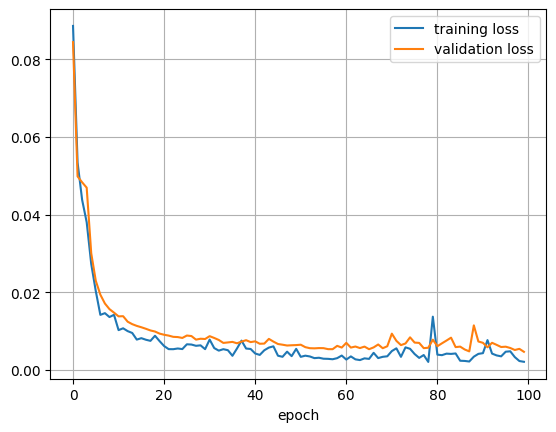

In [16]:
def plot_losses(training_loss, validation_loss):
    plt.plot(training_loss)
    plt.plot(validation_loss)
    plt.xlabel("epoch")
    plt.legend(["training loss", "validation loss"])
    plt.grid()


plot_losses(epoch_loss, epoch_validation_loss)

In [17]:
validation_input_patterns = []
validation_reconstructions = []
with torch.no_grad():
    for batch in validation_dataloader:
        input_patterns, _ = batch
        validation_input_patterns.append(input_patterns.detach().numpy())
        input_patterns = input_patterns.reshape(-1, 64 * 64)
        input_patterns = input_patterns.to(device)
        validation_reconstructions.append(
            autoencoder(input_patterns).detach().cpu().numpy()
        )
validation_set = np.vstack(validation_input_patterns)
reconstructed_set = np.vstack(validation_reconstructions)

In [18]:
import random


def plot_randomly_selected_results(num_images, input_images, output_images):
    # Randomly selected images from the validation set
    indxs = random.sample(range(len(output_images)), num_images)
    min_value = np.min(input_images)
    max_value = np.max(input_images)

    fig, axs = plt.subplots(2, num_images, figsize=(10, 4))
    for i in range(num_images):
        original_img = input_images[indxs[i]]
        reconstructed_img = output_images[indxs[i]].reshape(64, 64)
        axs[0, i].imshow(np.squeeze(original_img), vmin=min_value, vmax=max_value)
        axs[0, i].axis("off")
        axs[0, i].set_title(f"Image {indxs[i]}")
        axs[1, i].imshow(np.squeeze(reconstructed_img), vmin=min_value, vmax=max_value)
        axs[1, i].axis("off")
        axs[1, i].set_title(f"Reconstruction {indxs[i]}")
    plt.subplots_adjust(wspace=0.3, hspace=0.2)


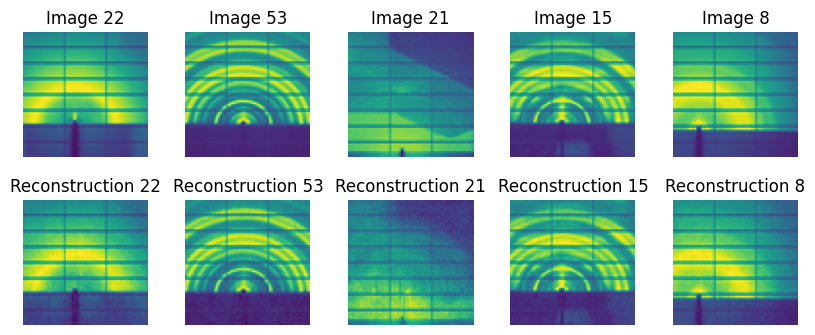

In [19]:
plot_randomly_selected_results(5, validation_set, reconstructed_set)

# Bonus - Using PyTorch Lightning

[PyTorch Lightning](https://lightning.ai/docs/pytorch/latest/starter/introduction.html) simplifies the code around deep learning models by removing the need for some of the boilerplate code while retaining similar structure. 

Instead of a subclass of `nn.Module` we need to create a subclass `pl.LightningModule`. 

Training and prediction use a [`Trainer()`](https://lightning.ai/docs/pytorch/stable/common/trainer.html) that comes with control over logging, acceleration, ...

In [20]:
!pip install -q pytorch-lightning

In [21]:
import pytorch_lightning as pl
import os

# define the LightningModule
class LitAutoEncoder(pl.LightningModule):
    def __init__(self, input_size=64 * 64, latent_dim=32):
        # This is the same as the previous AutoEncoder __init__ function
        super().__init__()

        self.input_size = input_size
        self.latent_dim = latent_dim

        self.encoder = Encoder(input_size=self.input_size, latent_dim=self.latent_dim)
        self.decoder = Decoder(latent_dim=self.latent_dim, output_size=self.input_size)

        self.loss_function = nn.MSELoss()

    def forward(self, x):
        # Remove labels
        input_patterns, _ = x
        # Reshapce here
        input_patterns = input_patterns.reshape(-1, self.input_size)
        # Pass through the autoencoder
        latent_representations = self.encoder(input_patterns)
        reconstructions = self.decoder(latent_representations)
        return reconstructions

    def _get_loss(self, batch):
        input_patterns, _ = batch
        reconstructions = self.forward(batch)
        input_patterns = input_patterns.reshape(-1, self.input_size)
        loss = self.loss_function(reconstructions, input_patterns)
        return loss

    def training_step(self, batch, batch_idx):
        loss = self._get_loss(batch)
        self.log("training loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self._get_loss(batch)
        self.log(
            "validation loss",
            loss,
            on_epoch=True,  # automatically averages over all batches
        )
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(), lr=hyper_parameters["learning_rate"]
        )
        return optimizer


# Init the autoencoder
pl_autoencoder = LitAutoEncoder(
    input_size=64 * 64, latent_dim=hyper_parameters["latent_dim"]
)

In [26]:
# Train the model
trainer = pl.Trainer(
    max_epochs=hyper_parameters["num_epochs"],
    # Log every epoch (a step is one batch)
    log_every_n_steps=len(train_dataset) / hyper_parameters["batch_size"],
    logger=pl.loggers.CSVLogger(save_dir=os.getcwd())
)
trainer.fit(
    model=pl_autoencoder,
    train_dataloaders=train_dataloader,
    val_dataloaders=validation_dataloader,
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
  | Name          | Type    | Params
------------------------------------------
0 | encoder       | Encoder | 2.1 M 
1 | decoder       | Decoder | 2.1 M 
2 | loss_function | MSELoss | 0     
------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.796    Total estimated model params size (MB)


Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 84.54it/s, v_num=18] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 63.43it/s, v_num=18]


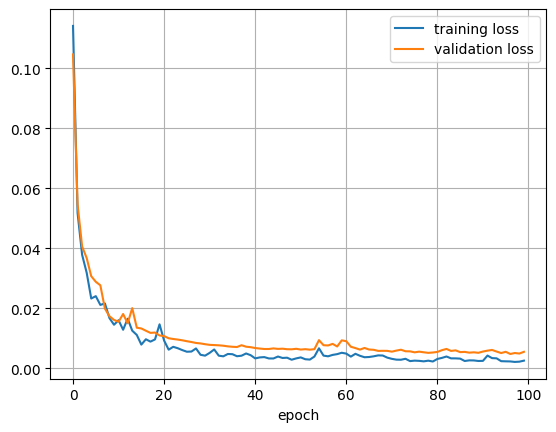

In [27]:
import pandas as pd

logs_path = f"{trainer.log_dir}/{trainer.logger.name}/version_{trainer.logger.version}/metrics.csv"
# print("Reading logs from", logs_path)
df = pd.read_csv(logs_path)

plot_losses(
    df["training loss"].dropna().reset_index(drop=True),
    df["validation loss"].dropna().reset_index(drop=True),
)


In [28]:
validation_reconstructions = trainer.predict(
    model=pl_autoencoder, dataloaders=validation_dataloader
)
pl_reconstructed_set = np.vstack(validation_reconstructions)


/Users/wiebke/Documents/Projects/2023.08 ML User Meeting/als_ml_tutorial/als_ml_tutorial-venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 246.45it/s]


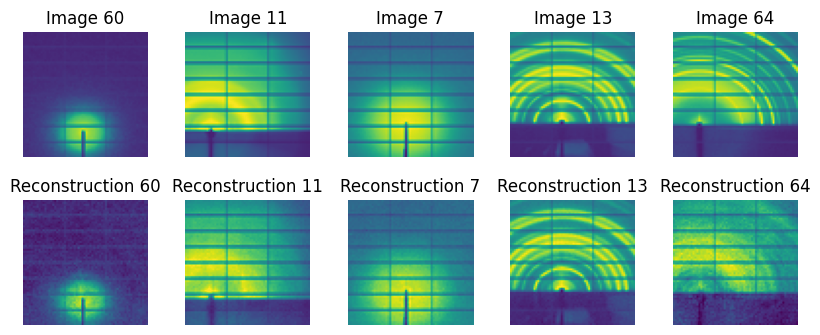

In [29]:
plot_randomly_selected_results(5, validation_set, pl_reconstructed_set)
